# Movie Data Analysis

This notebook explores the data gathered from the IMDb and OMDb databases.

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import json



In [5]:
#load in dataset
df = pd.read_csv("../data/movie_ratings_simple.csv")
len(df)

16470

I plot the number of films in the database per year to see how the movie industry has grown over time.

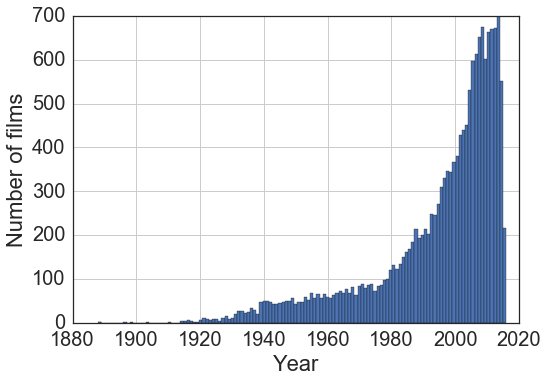

In [8]:
sns.set(font_scale=2)
sns.set_style("white")

#what do the years look like?
df['year'].hist(bins=max(df['year'])-min(df['year'])+1)
plt.xlabel("Year")
plt.ylabel("Number of films")
plt.savefig("../docs/filmsperyear.png")

# Film Ratings

I next look at the average rating of all the films in the database.

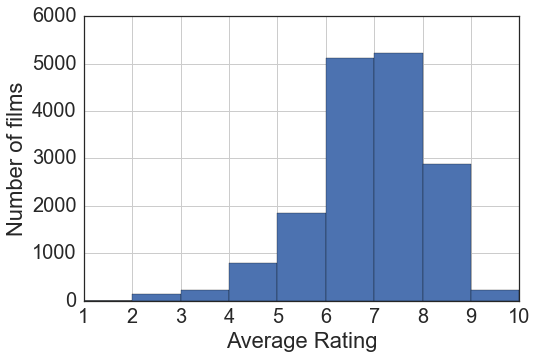

In [9]:
df['stars'].hist(bins=9)
plt.xlabel("Average Rating")
plt.ylabel("Number of films")
plt.tight_layout()
plt.savefig("../docs/ratinghist.png")

How has the average rating changed over time? As the number of films increase, this number should become less noisy.

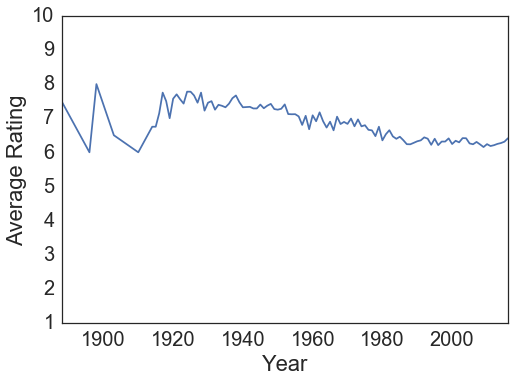

In [13]:
filmsperyear=df[['year','stars']].groupby('year').count()
filmsperyear.columns=['NFilms']

starsperyear=df[['year','stars']].groupby('year').mean()
starsperyear.plot()
plt.gca().legend_.remove()
plt.ylim((1,10))
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.savefig("../docs/ratingbyyear.png")
#starsperyear

# Genres

I next look at the genre distribution - how many films are there from each genre?

27


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

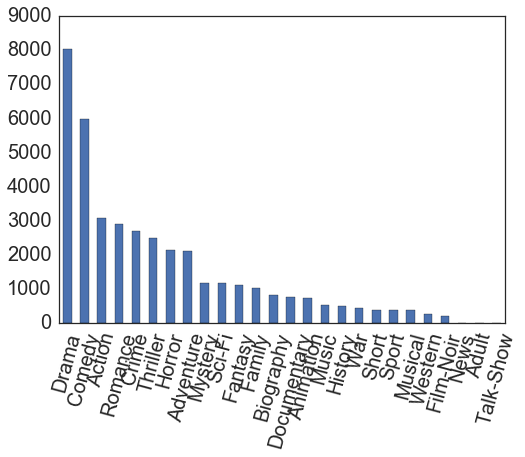

In [14]:
genres=pd.concat([df['Genre1'],df['Genre2'],df['Genre3']])
ungen = genres.unique()
print(len(genres.unique()))
genres.value_counts()[1:].plot(kind='bar')
plt.xticks(rotation='75')

I now put all the genres into a single column with the *year* and *stars* features so I can look at overall genre statistics. This means movies with multiple genres are counted multiple times.

In [15]:
dfG1 = df[['year','stars','Genre1']]
dfG1.columns = ['year','stars','Genre1']
dfG2 = df[['year','stars','Genre2']]
dfG2.columns = ['year','stars','Genre']
dfG3 = df[['year','stars','Genre3']]
dfG3.columns = ['year','stars','Genre']
dfG = dfG1.append(dfG2).append(dfG3)

dfG['Genre'] = dfG['Genre'].astype('category')
dfG['Genre'].describe()


count     32940
unique       25
top        None
freq      10066
Name: Genre, dtype: object

How have the ratings for the different genres changed over time? I normalize the genre ratings based on the overall average film rating for each year.

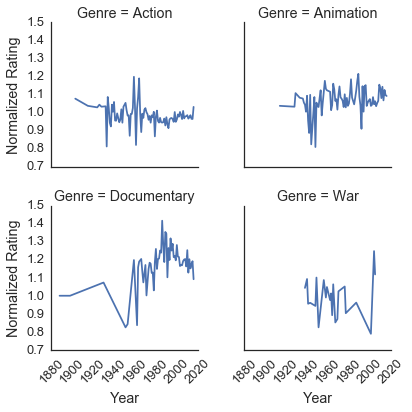

In [19]:
def normalizeStars(row):
    return row['stars']/starsperyear.loc[row['year']]
genresbyyearrev=dfG.groupby(['year','Genre']).mean()
genredatabyyear = genresbyyearrev.reset_index()
genredatabyyear
genredatabyyear['norm']=genredatabyyear.apply(lambda x: normalizeStars(x),axis=1)
#genredatabyyear

sns.set(font_scale=1.3)
sns.set_style("white")

genredatabyyear = genredatabyyear[(genredatabyyear['Genre'].isin(['Action','Animation','Documentary','War']))]
genredatabyyear['Genre']=genredatabyyear['Genre'].cat.remove_unused_categories()
g = sns.FacetGrid(genredatabyyear, col='Genre',col_wrap=2)
g = g.map(plt.plot, 'year','norm')
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
g.set_xlabels('Year')
g.set_ylabels('Normalized Rating')
plt.tight_layout()
plt.savefig("../docs/ratingbygenre.png")

What fraction of the total films were listed as each one of these genres?

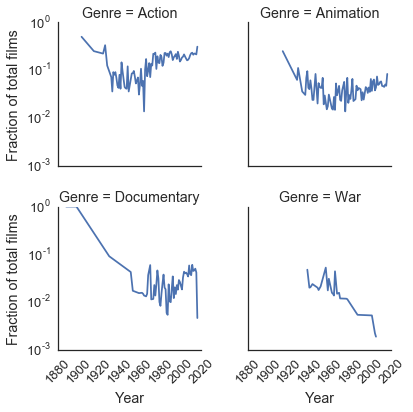

In [20]:
def normalizeYears(row):
    return row['stars']/filmsperyear.loc[row['year']]

genresbyyear2=dfG.groupby(['year','Genre']).count()
genredata2 = genresbyyear2.reset_index()
genredata2 = genredata2[(genredata2['Genre'].isin(['Action','Animation','Documentary','War']))]
genredata2['Genre']=genredata2['Genre'].cat.remove_unused_categories()
genredata2['norm']=genredata2.apply(lambda x: normalizeYears(x),axis=1)
g = sns.FacetGrid(genredata2, col='Genre',col_wrap=2)
g = g.map(plt.semilogy, 'year','norm')
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
g.set_xlabels('Year')
g.set_ylabels('Fraction of total films')
plt.tight_layout()
plt.savefig("../docs/nfilmsbygenre.png")

# Directors

Who are the directors with the most films?

6778


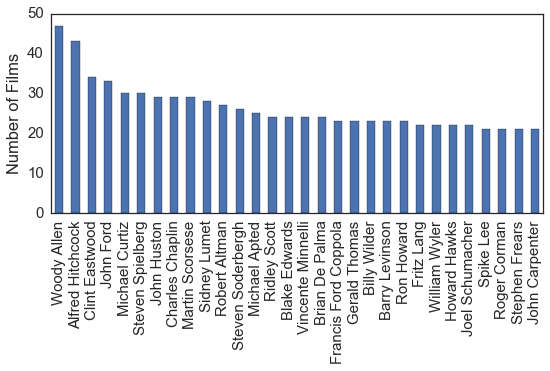

In [21]:
sns.set(font_scale=1.5)
sns.set_style("white")
directors=df['Director1']
print(len(directors.unique()))
vc=directors.value_counts()
subdir = vc[vc>1]
subdir[:30].plot(kind='bar')
plt.ylabel("Number of Films")
plt.tight_layout()
plt.savefig("../docs/director_nfilms.png")

How does a director's average rating depend on the number of films they have made?

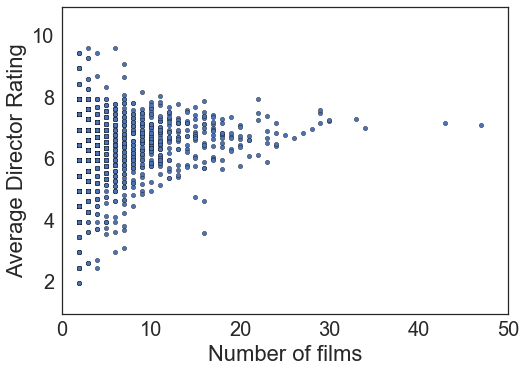

In [22]:
sns.set(font_scale=2)
sns.set_style("white")
directorrating=df[['Director1','stars']].groupby('Director1').mean()
nfilms = subdir.reset_index()
nfilms.columns = ['Director1','nfilms']
directorByRating=(directorrating.reset_index()).merge(nfilms,on='Director1')
directorByRating.plot(kind='scatter',x='nfilms',y='stars',xlim=(0,50))
plt.xlabel('Number of films')
plt.ylabel('Average Director Rating')
plt.savefig("../docs/director_ratings_by_film.png")

Who are the highest rated directors with more than 20 films to their name?

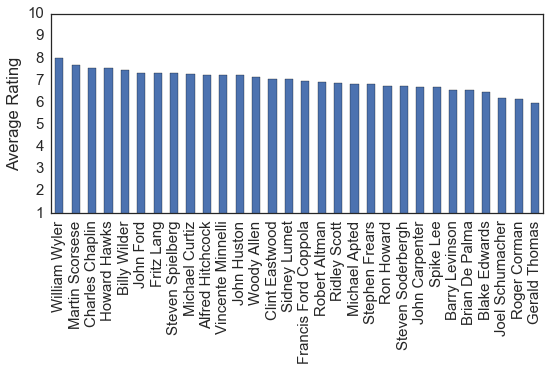

In [23]:
sns.set(font_scale=1.5)
sns.set_style("white")
directorByRating[directorByRating['nfilms']>20].sort_values('stars',ascending=False).plot(kind='bar',x='Director1',y='stars')
plt.gca().legend_.remove()
plt.ylim(1,10)
plt.xlabel('')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.savefig("../docs/bestdirector.png")

# AWS Trained Model

I trained a machine learning model using the Amazon Web Service machine learning app. The target was to predict the rating (in stars) based on a random grouping of **director**, **year**, and the three possible **Genres** (including the possibility that one or two of the genres were `none`.

The confusion matrix for the prediction is shown below. The models does not do a very good job of predicting the output.

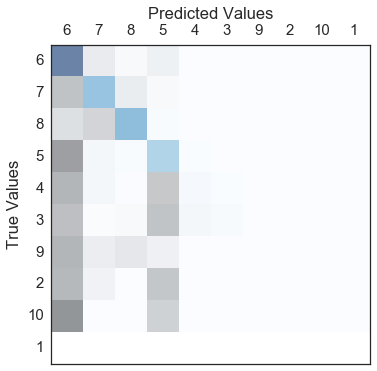

In [26]:
model = pd.read_csv("../data/multiclass-model_0919.csv",index_col=0)
rowtotals = model['Total']
model.drop(['Total','F1'],axis=1,inplace=True)
nevals=(model.sum().sum())
model = model.div(rowtotals,axis='rows')

def removeDiag(row):
    row.loc[str(row.name)]= 0
    return row

model_bad = model.copy().apply(lambda x: removeDiag(x) ,axis=1)

model_good = model.subtract(model_bad,axis='rows')


sns.set_style('white')
plt.imshow(model_bad, interpolation='nearest')
plt.hold(True)
plt.imshow(model_good, interpolation='nearest', alpha=.6,cmap=plt.cm.Blues)
plt.xticks(np.arange(0,10),model.columns.values)
plt.yticks(np.arange(0,10),model.index.values)
plt.gca().xaxis.tick_top()
plt.xlabel('Predicted Values')
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('True Values')
plt.tight_layout()
plt.savefig("../docs/conf_matrix.png")